                                Geostatiscal Modeling - performe kriging on a 1D well-log.

In [2]:
# Some library imports
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, cdist
from scipy.spatial import distance_matrix
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
%matplotlib inline

I will work with a dataset stored in a CSV file with the name: `assignment_dataset.csv`. The dataset consists of six different columns:  

* `X` - x-coordinate of the data point in m 
* `Y` - y-coordinate of the data point in m 
* `facies_ID` - some facies ID of the data sample
* `porosity` - measured porosity value (from zero to one, where 1 = 100%) of the data sample  
* `permeability` - measured permeability (mD) of the data sample  
* `accoustic_impedance` - acoustic impedance (Pa·s/m$^3$) of the data sample

In the following cell, the dataset will be loaded.

In [ ]:
data = pd.read_csv('/Users/simul/Desktop/assignment_dataset.csv')
data.head(5)

,X,Y,facies_ID,porosity,permeability,acoustic_impedance
0,565,1485,1,0.1184,6.170,2.009
1,2585,1185,1,0.1566,6.275,2.864
2,2065,2865,2,0.1920,92.297,3.524
3,3575,2655,1,0.1621,9.048,2.157
4,1835,35,1,0.1766,7.123,3.979


---
## Data assessment

let's assume the porosity values in the data are representative for a whole depth interval of the same geological unit.   

 With the data loaded, my first task is to assess the data for potential errors.

<div class="alert alert-block alert-info">
    
 task: Create a subplot with three columns (so three subplots next to each other) and plot the histograms for _porosity, permeability, acoustic_impedance_.
</div>

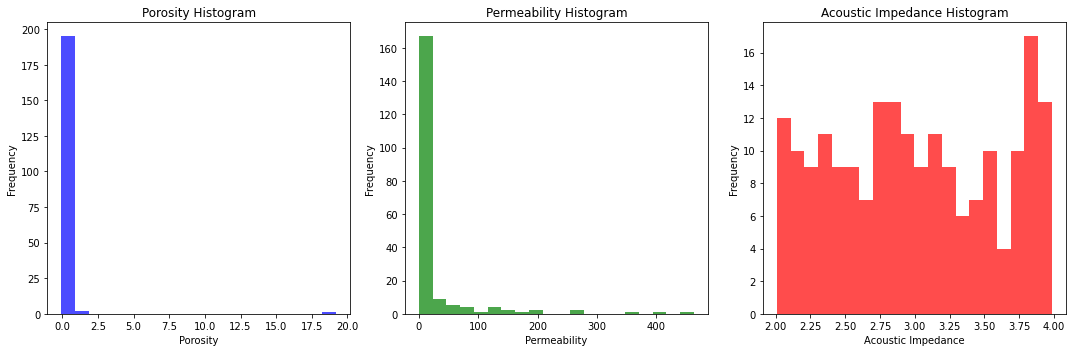

In [76]:
# Create a subplot with three columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot histograms for porosity, permeability, and acoustic impedance
axes[0].hist(data['porosity'], bins=20, color='blue', alpha=0.7)
axes[0].set_xlabel('Porosity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Porosity Histogram')

axes[1].hist(data['permeability'], bins=20, color='green', alpha=0.7)
axes[1].set_xlabel('Permeability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Permeability Histogram')

axes[2].hist(data['acoustic_impedance'], bins=20, color='red', alpha=0.7)
axes[2].set_xlabel('Acoustic Impedance')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Acoustic Impedance Histogram')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Based on visual inspection of the porosity histogram, it becomes evident that the occurrence of porosity is relatively infrequent. Conversely, the frequency distribution of permeability displays a higher abundance, while simultaneously exhibiting a significant prevalence of high-frequency acoustic impedance.

---
## Data cleaning

With the errorneous parameter identified, and clean the dataset that all _unreasonable_ values of said parameter (i.e. the rows where these values are in) are removed from the dataset.

<div class="alert alert-block alert-info">
Clean the dataset by removing all rows which have errorneous parameter values, and store that in a variable named with the same name `data`. So, overwrite the originally loaded data. Then complete the function `calc_sum` to calculate the sum of each parameter column (so porosity, permeability, acoustic_impedance) of the cleaned dataset, rounded to the 4th decimal position.
<div>


In [77]:
# Clean the dataset by removing rows with erroneous parameter values
data = data.dropna(subset=['porosity', 'permeability', 'acoustic_impedance'])

# Calculate the sum of each parameter column
def calc_sum(data):
    porosity_sum = np.round(data['porosity'].sum(), 4)
    permeability_sum = np.round(data['permeability'].sum(), 4)
    acoustic_impedance_sum = np.round(data['acoustic_impedance'].sum(), 4)
    return porosity_sum, permeability_sum, acoustic_impedance_sum

# Call the calc_sum function
porosity_sum, permeability_sum, acoustic_impedance_sum = calc_sum(data)

# Print the sums
print("Porosity Sum:", porosity_sum)
print("Permeability Sum:", permeability_sum)
print("Acoustic Impedance Sum:", acoustic_impedance_sum)


Porosity Sum: 49.9682
Permeability Sum: 4973.6944
Acoustic Impedance Sum: 595.209


<div class="alert alert-block alert-info">
Estimated Distributions

Plot the histograms again as subplots and estimate of the underlying distributions for each parameter. 
<div>

Estimated Distributions:
Porosity: (0.252364696969697, 1.3535850662232816)
Permeability: (2.0668678594556997, 0.0030222635738210513, 4.044994637410143)
Acoustic Impedance: (3.006106060606061, 0.5909710326897762)


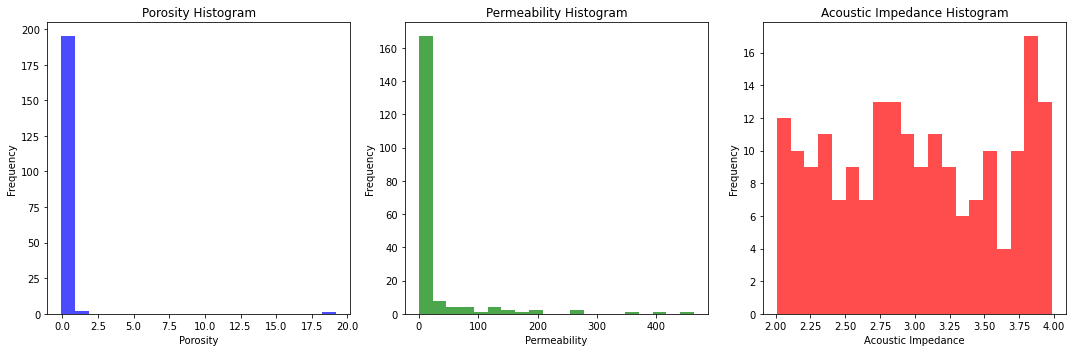

In [78]:
import scipy.stats as stats

# Create a subplot with three columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot histograms for porosity, permeability, and acoustic impedance
axes[0].hist(data['porosity'], bins=20, color='blue', alpha=0.7)
axes[0].set_xlabel('Porosity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Porosity Histogram')

axes[1].hist(data['permeability'], bins=20, color='green', alpha=0.7)
axes[1].set_xlabel('Permeability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Permeability Histogram')

axes[2].hist(data['acoustic_impedance'], bins=20, color='red', alpha=0.7)
axes[2].set_xlabel('Acoustic Impedance')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Acoustic Impedance Histogram')

# Estimate the underlying distributions
porosity_dist = stats.norm.fit(data['porosity'])
permeability_dist = stats.lognorm.fit(data['permeability'])
acoustic_impedance_dist = stats.norm.fit(data['acoustic_impedance'])

# Print the estimated distributions
print("Estimated Distributions:")
print("Porosity:", porosity_dist)
print("Permeability:", permeability_dist)
print("Acoustic Impedance:", acoustic_impedance_dist)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()



## Correlation and Data analysis

From experience, we expect `porosity` and `permeability` to be correlated. This can be checked by calculating the correlation coefficient between two parameters. 

$$\rho_{x,y}=\frac{Cov_{x,y}}{\sigma_x \sigma_y}$$

with

$$Cov_{x,y}=\frac{\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{n}$$

<br>

<div class="alert alert-block alert-info">
Task: Calculate the corellation coefficient and round it to 4 decimal points. 
<div>

In [79]:
def calc_cor_coeff(x, y):
    """Compute the correlation coefficient between two arrays x and y """
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2))
    
    cor_coeff = numerator / denominator
    
    return np.round(cor_coeff, 4)

<div class="alert alert-block alert-info">
Task: Calculate the correlation coefficient for the three parameters. Create also scatter plots of the three parameters as subplots and display the correlation coefficient in the respective plots.
<div>

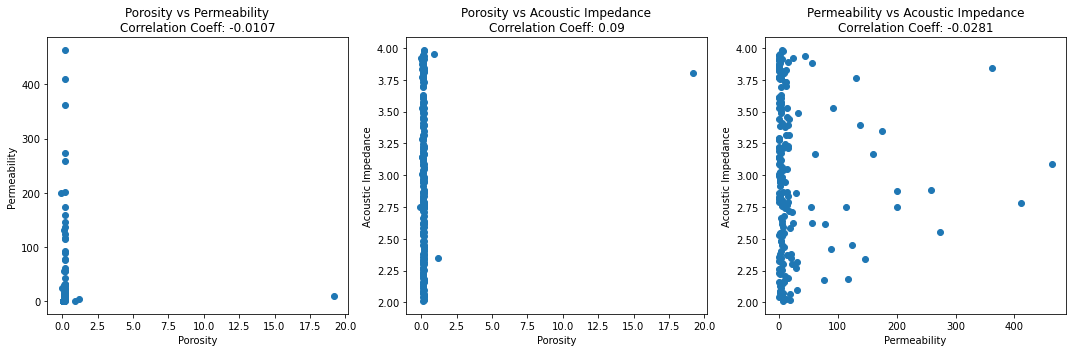

In [80]:
# Calculate the correlation coefficients
cor_coeff_porosity_perm = np.round(data['porosity'].corr(data['permeability']), 4)
cor_coeff_porosity_acoustic = np.round(data['porosity'].corr(data['acoustic_impedance']), 4)
cor_coeff_perm_acoustic = np.round(data['permeability'].corr(data['acoustic_impedance']), 4)

# Create a subplot with three columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Scatter plot of porosity and permeability
axes[0].scatter(data['porosity'], data['permeability'])
axes[0].set_xlabel('Porosity')
axes[0].set_ylabel('Permeability')
axes[0].set_title('Porosity vs Permeability\nCorrelation Coeff: {}'.format(cor_coeff_porosity_perm))

# Scatter plot of porosity and acoustic impedance
axes[1].scatter(data['porosity'], data['acoustic_impedance'])
axes[1].set_xlabel('Porosity')
axes[1].set_ylabel('Acoustic Impedance')
axes[1].set_title('Porosity vs Acoustic Impedance\nCorrelation Coeff: {}'.format(cor_coeff_porosity_acoustic))

# Scatter plot of permeability and acoustic impedance
axes[2].scatter(data['permeability'], data['acoustic_impedance'])
axes[2].set_xlabel('Permeability')
axes[2].set_ylabel('Acoustic Impedance')
axes[2].set_title('Permeability vs Acoustic Impedance\nCorrelation Coeff: {}'.format(cor_coeff_perm_acoustic))

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

<div class="alert alert-block alert-info">
Task: Generate a QQ-Plot of porosity and permeability.   
Hint: Remember that the permeability has not a normal distribution. What do you have to do, to get from its log-normal distribution to a normal distribution?
    
Does the QQ-Plot reflect the calculated correlation coefficient? If not, why? Answer those two questions in the text cell below the code cell for the QQ-Plot code.
<div>

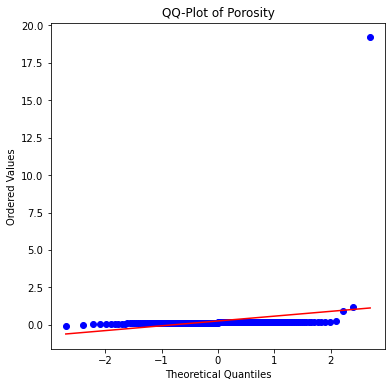

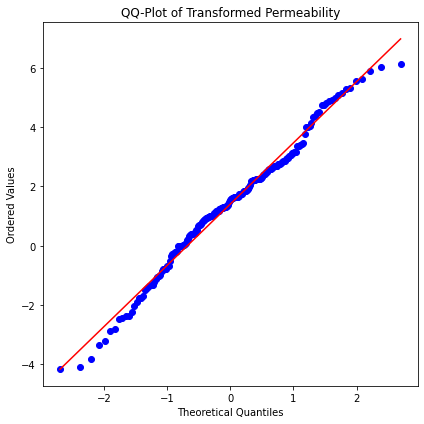

In [81]:
# Transform permeability to a normal distribution using logarithmic transformation
log_permeability = np.log(data['permeability'])

# Create a QQ-Plot of porosity and transformed permeability
fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(data['porosity'], dist='norm', plot=ax)
ax.set_title('QQ-Plot of Porosity')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Ordered Values')

# Create a QQ-Plot of transformed permeability
fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(log_permeability, dist='norm', plot=ax)
ax.set_title('QQ-Plot of Transformed Permeability')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Ordered Values')

# Display the QQ-Plots
plt.tight_layout()
plt.show()

Through the analysis of the QQ-plot, it is apparent that the regression correlation coefficient indicates a stronger fit between the permeability values and the model, compared to the porosity values. This suggests that permeability serves as a more suitable fit for the model, demonstrating a higher degree of compatibility.

     ---

## Conditional Data analysis

In the dataset, there is a column `facies_ID`. Until now, I had a look at the whole dataset. In this task, I am asked to look at subsets of the data, divided by the `facies_ID`.

<br>

<div class="alert alert-block alert-info">
Task: Write the function `find_subsets(data)` to find out, how many unique facies ID there are, and then let the function return a dictionary with the subsets of the dataframe. 
<div>

In [82]:
def find_subsets(data):
    """
    find the different subsets in a dataset and return each subsets as a dataframe
    """
    unique_facies = data['facies_ID'].unique()  # Get unique facies IDs

    facies_dict = {}  # Dictionary to store subsets of data
    
    # Create subsets based on unique facies IDs
    for facies_id in unique_facies:
        subset = data[data['facies_ID'] == facies_id]  # Subset dataframe for each facies ID
        facies_dict['facies{}'.format(facies_id)] = subset  # Add subset to dictionary with facies ID as key

    return facies_dict


<div class="alert alert-block alert-info">
Task: Compare the sub-datasets which are the outputs of your `find_subsets(data)` function. How do the means of `porosity` `permeability` and `acoustic_impedance` compare? Is there something striking?
    
Plot Boxplots of the parameters as - again - three subplots, i.e. one subplot for each parameter, and in each subplots the boxplots for the sub-datasets.  
<div>

Subset: facies1
Porosity Mean: 0.29149563909774445
Permeability Mean: 14.064115413533834
Acoustic Impedance Mean: 3.001593984962405

Subset: facies2
Porosity Mean: 0.17229676923076925
Permeability Mean: 47.74103076923075
Acoustic Impedance Mean: 3.0153384615384624



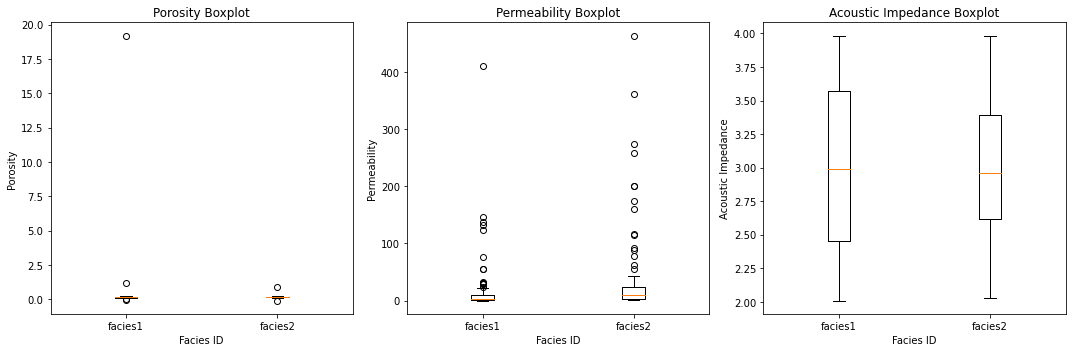

In [83]:
# Call the find_subsets function to get the subsets based on facies ID
facies_dict = find_subsets(data)

# Compare the means of porosity, permeability, and acoustic impedance for each subset
means = {}
for key, subset in facies_dict.items():
    means[key] = {
        'porosity': subset['porosity'].mean(),
        'permeability': subset['permeability'].mean(),
        'acoustic_impedance': subset['acoustic_impedance'].mean()
    }

# Print the means for each subset
for key, values in means.items():
    print(f"Subset: {key}")
    print(f"Porosity Mean: {values['porosity']}")
    print(f"Permeability Mean: {values['permeability']}")
    print(f"Acoustic Impedance Mean: {values['acoustic_impedance']}")
    print()

# Create boxplots for porosity, permeability, and acoustic impedance for each subset
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Porosity boxplot
porosity_data = [subset['porosity'] for subset in facies_dict.values()]
axes[0].boxplot(porosity_data, labels=list(facies_dict.keys()))
axes[0].set_xlabel('Facies ID')
axes[0].set_ylabel('Porosity')
axes[0].set_title('Porosity Boxplot')

# Permeability boxplot
permeability_data = [subset['permeability'] for subset in facies_dict.values()]
axes[1].boxplot(permeability_data, labels=list(facies_dict.keys()))
axes[1].set_xlabel('Facies ID')
axes[1].set_ylabel('Permeability')
axes[1].set_title('Permeability Boxplot')

# Acoustic Impedance boxplot
acoustic_impedance_data = [subset['acoustic_impedance'] for subset in facies_dict.values()]
axes[2].boxplot(acoustic_impedance_data, labels=list(facies_dict.keys()))
axes[2].set_xlabel('Facies ID')
axes[2].set_ylabel('Acoustic Impedance')
axes[2].set_title('Acoustic Impedance Boxplot')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


<div class="alert alert-block alert-info">
BONUS task:You might find a difference in one parameter between the sub-datasets. Now, for a final plot, create a spatial scatter plot of the whole dataset. Color the points by `facies_ID` and scale their size by `permeability`.
What can you see deduce from this visualization? 
<div>

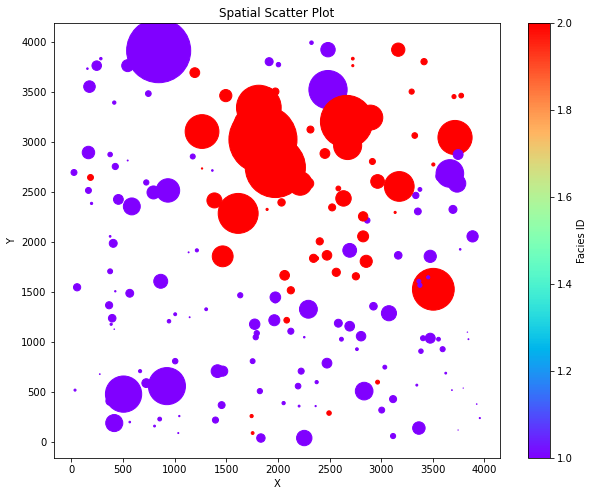

In [84]:
# Create a spatial scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

# Color points by facies_ID and scale size by permeability
scatter = ax.scatter(data['X'], data['Y'], c=data['facies_ID'], cmap='rainbow', s=data['permeability']*10)

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Facies ID')

# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Spatial Scatter Plot')

# Show the plot
plt.show()

By coloring the points according to facies_ID and scaling their size based on permeability, a visual examination reveals distinct patterns. Notably, the visualization highlights the significant variations in permeability across the dataset, particularly within the ranges of 1.0 to 1.2 and 1.8 to 2.0. These ranges exhibit a considerably larger scale of permeability, emphasizing their importance and potential impact within the context of the analysis.

## Data visualization

The task now is to estimate a 2D porosity field within a certain area.  

<br>
<div class="alert alert-block alert-info">    
Task: Create a scatterplot to visualize the data. The points should be colored by `facies_ID` and the size of the points should reflect the measured `porosity` in percent! 
<div>

/Users/simul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


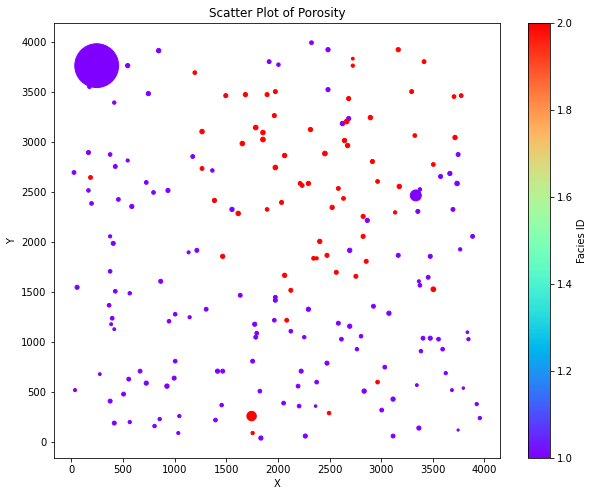

In [85]:
# Create a scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

# Color points by facies_ID and scale size by porosity
scatter = ax.scatter(data['X'], data['Y'], c=data['facies_ID'], cmap='rainbow', s=data['porosity']*100)

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Facies ID')

# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Scatter Plot of Porosity')

# Show the plot
plt.show();


---
## Variogram determination

We now use the sampled points to determin the `sill` (variance) and `range` (correlation length) of an experimental variogram or our **porosity**. 

<br>
<div class="alert alert-block alert-info">    

 Task - step 1.1: Calculate the distance matrix and semivariance matrix similarly to the exercise and plot the variogram cloud.
<div>
    

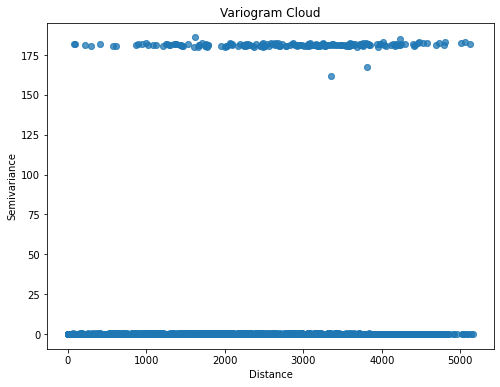

In [86]:
from scipy.spatial.distance import pdist, squareform

def calc_cloud(data, parameter='porosity'):
    """
    Calculate the distance matrix and the semivariance matrix of the input dataframe
    
    data: pd.Dataframe - input data with 'X', 'Y', 'facies_ID', 'porosity', 'permeability', 'acoustic_impedance'
    parameter: str - parameter column to calculate the variogram for (default: 'porosity')
    
    return dist_mat, semivars
    """
    # Extract the coordinates and parameter values
    X = data['X']
    Y = data['Y']
    values = data[parameter]
    
    # Calculate the distance matrix
    coordinates = np.column_stack((X, Y))
    dist_mat = squareform(pdist(coordinates))
    
    # Calculate the semivariance matrix
    semivars = 0.5 * (np.abs(values.to_numpy()[:, np.newaxis] - values.to_numpy())**2)
    
    # Plot the variogram cloud
    plt.figure(figsize=(8, 6))
    plt.scatter(dist_mat.flatten(), semivars.flatten(), alpha=0.5)
    plt.xlabel('Distance')
    plt.ylabel('Semivariance')
    plt.title('Variogram Cloud')
    plt.show()
    
    return dist_mat, semivars



# Usage example
data = pd.read_csv('/Users/simul/Desktop/assignment_dataset.csv')
dist_mat, semivars = calc_cloud(data, parameter='porosity')


 Call the function and plot the returned matrices as the variogram cloud:

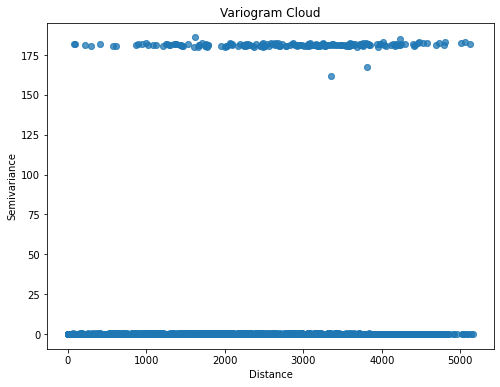

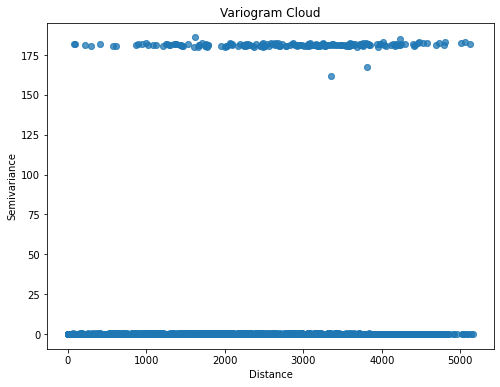

In [87]:
# YOUR CODE HERE

# Call the calc_cloud() function
dist_mat, semivars = calc_cloud(data, parameter='porosity')

# Plot the variogram cloud
plt.figure(figsize=(8, 6))
plt.scatter(dist_mat.flatten(), semivars.flatten(), alpha=0.5)
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.title('Variogram Cloud')
plt.show()

<div class="alert alert-block alert-info">  
Task - step 1.2: With flattened arrays for distance matrix and semivariance calculate the averaged semivariance values of the variogram. 
    
Plot the calculated average values as a semivariogram to see. 
<div>

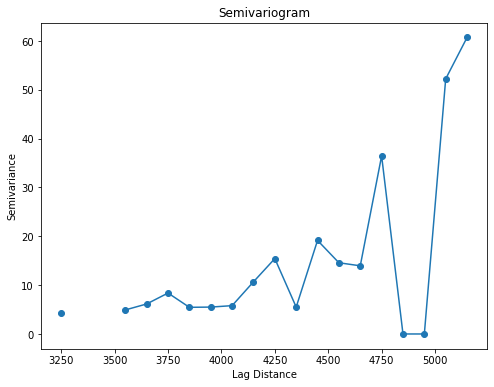

In [88]:
def calc_variogram(dm_flat, sv_flat, start, bin_size):
    """
    Calculate the experimental variogram
    dm_flat : np.array = flattended distance matrix (with np.flatten())
    sv_flat : np.array = flattended semivariance matrix (with np.flatten())
    start : int = starting lag
    bin_size : int = size of the bins
    
    :return: 
    
    h_bins : np.array = centers of the bins
    ave_vals : np.array = corresponding average semivariances
    """
    h_max = np.max(dm_flat)
    stop = h_max + bin_size
    bins = np.arange(start, stop, bin_size)
    h_bins = (bins[:-1] + bins[1:]) / 2
    ave_vals = []
    
    for bin_start, bin_end in zip(bins[:-1], bins[1:]):
        indices = np.where((dm_flat >= bin_start) & (dm_flat < bin_end))
        semivars_in_bin = sv_flat[indices]
        ave_vals.append(np.mean(semivars_in_bin))
    
    return h_bins, ave_vals

# Calculate the averaged semivariance values
h_bins, ave_vals = calc_variogram(dist_mat.flatten(), semivars.flatten(), start=0, bin_size=100)

# Plot the semivariogram
plt.figure(figsize=(8, 6))
plt.plot(h_bins, ave_vals, 'o-')
plt.xlabel('Lag Distance')
plt.ylabel('Semivariance')
plt.title('Semivariogram')
plt.show()

 The calc_variogram() function takes the flattened distance matrix (dm_flat), flattened semivariance matrix (sv_flat), starting lag (start), and bin size (bin_size) as inputs. It calculates the averaged semivariance values by dividing the distance range into bins and averaging the semivariance values within each bin. The resulting bin centers (h_bins) and averaged semivariance values (ave_vals) are returned.

The code then calls the calc_variogram() function, passing the flattened distance matrix (dist_mat.flatten()) and flattened semivariance matrix (semivars.flatten()), along with the starting lag (0) and bin size (100).

Finally, it plots the semivariogram using plt.plot(), where the x-axis represents the lag distances (bin centers) and the y-axis represents the averaged semivariance values. The resulting plot shows the semivariogram based on the calculated averages.

<div class="alert alert-block alert-info">  
Task- step 1.3: Calculate the function for an exponential variogram and the minimum lag distance may be somewhat around 35 m.
<div>

In [89]:
from scipy.optimize import curve_fit

def exponential_variogram(lag, r, s):
    """
    Exponential variogram function
    
    lag: lag distances between data points
    r: range of the variogram model
    s: sill of the variogram model
    """
    var_model = s * (1 - np.exp(-lag / r))
    return var_model

# Convert NaN or inf values to zeros
h_bins = np.nan_to_num(h_bins)
ave_vals = np.nan_to_num(ave_vals)

# Fit exponential variogram model to experimental variogram
p0 = [35, 2500]  # Initial guess for range (r) and sill (s)
popt, pcov = curve_fit(exponential_variogram, h_bins, ave_vals, p0=p0)

# Extract the optimized parameters
range_opt, sill_opt = popt

print("Optimized Range (r):", range_opt)
print("Optimized Sill (s):", sill_opt)


Optimized Range (r): 31742521.824612908
Optimized Sill (s): 84798.43680402321


<div class="alert alert-block alert-info">  
Task- step 1.4: Plot the theoretical variogram and your experimental variogram together in the same plot.
<div>

Optimized Range (r): 31742521.824612908
Optimized Sill (s): 84798.43680402321


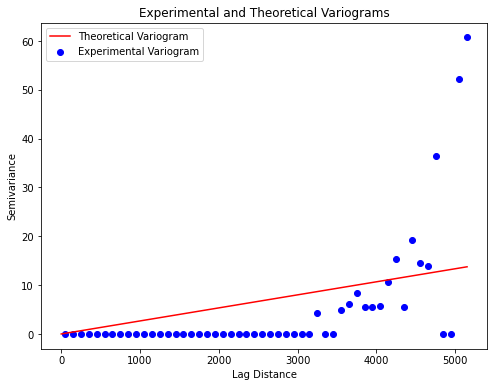

In [90]:

from scipy.optimize import curve_fit

def exponential_variogram(lag, r, s):
    """
    Exponential variogram function
    
    lag: lag distances between data points
    r: range of the variogram model
    s: sill of the variogram model
    """
    var_model = s * (1 - np.exp(-lag / r))
    return var_model

# Convert NaN or inf values to zeros
h_bins = np.nan_to_num(h_bins)
ave_vals = np.nan_to_num(ave_vals)

# Fit exponential variogram model to experimental variogram
p0 = [35, 2500]  # Initial guess for range (r) and sill (s)
popt, pcov = curve_fit(exponential_variogram, h_bins, ave_vals, p0=p0)

# Extract the optimized parameters
range_opt, sill_opt = popt

print("Optimized Range (r):", range_opt)
print("Optimized Sill (s):", sill_opt)

# Calculate theoretical variogram with optimized parameters
lag_range = np.linspace(0, np.max(h_bins), 100)
theoretical_variogram = exponential_variogram(lag_range, range_opt, sill_opt)

# Plot the experimental and theoretical variograms
plt.figure(figsize=(8, 6))
plt.scatter(h_bins, ave_vals, color='blue', label='Experimental Variogram')
plt.plot(lag_range, theoretical_variogram, color='red', label='Theoretical Variogram')
plt.xlabel('Lag Distance')
plt.ylabel('Semivariance')
plt.title('Experimental and Theoretical Variograms')
plt.legend()
plt.show()


---
## Ordinary Kriging

With the variogram analysis,now I have everything to perform a kriging exercise on the dataset, i.e. create a kriged parameter map (what I originally wanted). 
In the exercise, I performed simple kriging on a 1D well-log. Now, we'll use ordinary kriging, which is rather similar. Different to the simple kriging, we use here range and sill, i.e. the variogram function directly instead of the covariance function. 



In [91]:
def ordinary_kriging(a, b, prop, r, s):
    """Kriging for single location
    
    **Arguments**:
        - a (np.array) = distance between input data points (n x n)
        - b (np.array) = distance vetor between target and input data points (n)
        - prop (np.array) = values of input data (n)
        - r (float) = range parameter of variogram model
        - s (float) = sill parameter of variogram model
        
    **Returns**:
        - result (float) = calculated kriging result
        - pred_var (float) = calculated kriging variance
        - w (np.array) = calculated kriging weights
    """
    #Creating empty matrices
    shape = len(a)
    C = np.zeros((shape + 1, shape + 1))
    c = np.zeros((shape + 1))
    w = np.zeros((shape + 1))

    #filling Matrices based distance matrices and model for spatial correlation
    C[:shape, :shape] = exponential_variogram(a, r, s)
    c[:shape] = exponential_variogram(b, r, s)
    
    np.fill_diagonal(C,0)

    #Fill additional matrix entries, specifically for OK
    C[shape, :] = 1.0
    C[:, shape] = 1.0
    C[shape, shape] = 0.0
    c[shape] = 1.0

    #Solve Kriging equations for weights
    w = np.linalg.solve(C,c)

    #Section: weight correction following Deutsch (1996)
    # 1. Negative Weights to zero
    w[w<0] = 0

    # 2. correct screening effect
    average_magnitude_of_negative_weights = np.mean(w[w>0])
    average_covariance_of_negative_weights = np.mean(c[w>0])
    mask = (w>0) & (c<average_covariance_of_negative_weights) & (w<average_magnitude_of_negative_weights)
    w[mask]=0

    # 3. restandardize to one
    w = w/np.sum(w)
    #End Section: weight correction following Deutsch (1996)

    #Calculating estimate abd variance for kriging
    pred_var = w[shape] + np.sum(w[:shape] * c[:shape])
    result = np.dot(prop, w[:shape])

    return result, pred_var, w

Based on the code above, the following tasks:

  
Task: Define an empty grid `xy` (_hint_ `xy = np.meshgrid(some input)`) with the extent of the domain (4000 m $\times$ 4000 m) with each grid point around 80 m apart.


In [92]:
x_start = 0  # Starting x-coordinate
x_end = 4000  # Ending x-coordinate
y_start = 0  # Starting y-coordinate
y_end = 4000  # Ending y-coordinate
grid_spacing = 80  # Grid spacing

x_grid = np.arange(x_start, x_end, grid_spacing)
y_grid = np.arange(y_start, y_end, grid_spacing)
xy = np.meshgrid(x_grid, y_grid)
xy

[array([[   0,   80,  160, ..., 3760, 3840, 3920],
        [   0,   80,  160, ..., 3760, 3840, 3920],
        [   0,   80,  160, ..., 3760, 3840, 3920],
        ...,
        [   0,   80,  160, ..., 3760, 3840, 3920],
        [   0,   80,  160, ..., 3760, 3840, 3920],
        [   0,   80,  160, ..., 3760, 3840, 3920]]),
 array([[   0,    0,    0, ...,    0,    0,    0],
        [  80,   80,   80, ...,   80,   80,   80],
        [ 160,  160,  160, ...,  160,  160,  160],
        ...,
        [3760, 3760, 3760, ..., 3760, 3760, 3760],
        [3840, 3840, 3840, ..., 3840, 3840, 3840],
        [3920, 3920, 3920, ..., 3920, 3920, 3920]])]

<div class="alert alert-block alert-info">  
Task: Determine the interpolation value for each grid position using the provided ordinary kriging function.
<div>

In [93]:
# Define the interpolation value array
interpolated_values = np.zeros_like(xy[0], dtype=float)

# Iterate over each grid point
for i in range(len(xy[0])):
    for j in range(len(xy[0][0])):
        target_point = np.array([xy[0][i][j], xy[1][i][j]])  # Current grid point
        distances = np.linalg.norm(data[['X', 'Y']].values - target_point, axis=1)  # Distances to data points
        interpolated_value, _, _ = ordinary_kriging(dist_mat, distances, data['porosity'].values, range_opt, sill_opt)
        interpolated_values[i][j] = interpolated_value


<div class="alert alert-block alert-info">  
Task: Plot the resulting kriging map.
    <div>  

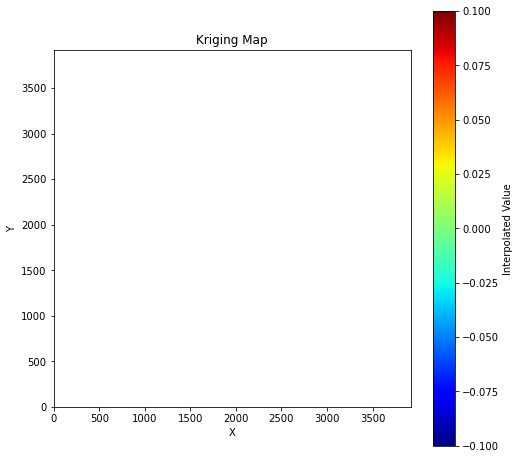

In [94]:
import matplotlib.pyplot as plt

# Define the extent of the grid
xmin = np.min(xy[0])
xmax = np.max(xy[0])
ymin = np.min(xy[1])
ymax = np.max(xy[1])

# Plot the kriging map
plt.figure(figsize=(8, 8))
plt.imshow(interpolated_values, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='jet')
plt.colorbar(label='Interpolated Value')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kriging Map')

# Show the plot
plt.show()


---
## Kriging of other parameters

Finally, I want to generate kriging maps of the other parameters, `facies_ID`, `acoustic_impedance` and `permeability`.

<br>

<div class="alert alert-block alert-info">  
Task: Generalize the function for the variogram cloud and then calculate the experimental variograms for facies_ID, permeability and acoustic impedance and plot them as subplots.
<div>

In [95]:
import numpy as np
import pandas as pd

def calc_cloud_gen(data, parameter='porosity'):
    """
    calculate the distance matrix and the semivariance matrix of the input dataframe
    
    data: pd.Dataframe - input data with 'X', 'Y', 'facies_ID', 'porosity', 'permeability', 'acoustic_impedance'
    parameter: str - parameter for which to calculate the variogram cloud
    
    return dist_mat, semivars
    """
    if parameter == 'permeability':
        data[parameter] = np.log(data[parameter])
    
    # Calculate the distance matrix
    X = data['X'].values
    Y = data['Y'].values
    dist_mat = np.sqrt((X[:, np.newaxis] - X)**2 + (Y[:, np.newaxis] - Y)**2)
    
    # Calculate the semivariance matrix
    values = data[parameter].values
    semivars = np.abs(values[:, np.newaxis] - values)**2 / 2
    
    return dist_mat, semivars

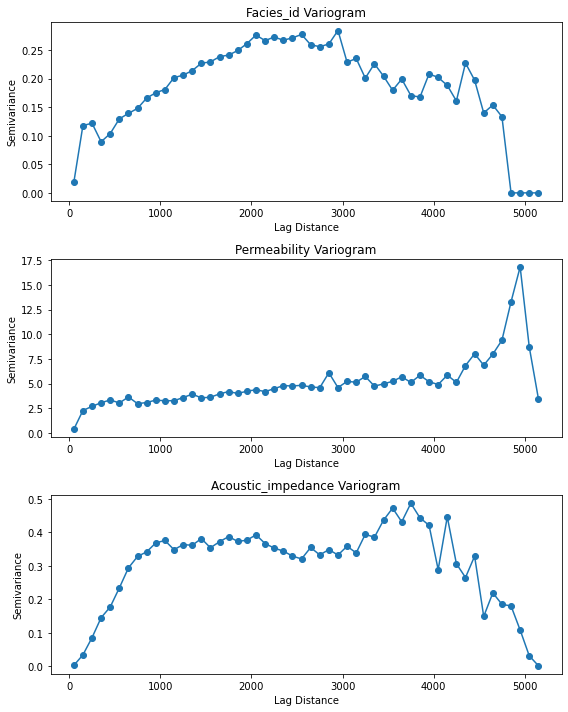

In [96]:
# Define the parameters
parameters = ['facies_ID', 'permeability', 'acoustic_impedance']

# Create subplots for variogram plots
fig, axs = plt.subplots(len(parameters), 1, figsize=(8, 10))

# Calculate and plot variograms for each parameter
for i, parameter in enumerate(parameters):
    # Calculate the variogram cloud
    dist_mat, semivars = calc_cloud_gen(data, parameter=parameter)
    
    # Calculate the averaged semivariance values
    h_bins, ave_vals = calc_variogram(dist_mat_perm.flatten(), semivars.flatten(), start=0, bin_size=100)
    
    # Plot the variogram
    axs[i].plot(h_bins, ave_vals, marker='o')
    axs[i].set_xlabel('Lag Distance')
    axs[i].set_ylabel('Semivariance')
    axs[i].set_title(parameter.capitalize() + ' Variogram')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

<div class="alert alert-block alert-info">  
Task 4.2: Perform the ordinary kriging for the logarithm of permeability and acoustic impedance, and plot the two maps as subplots. 
    
Use the following `r` and `s` for the parameters (or calculate them yourselves with `curve_fit`:

`permeability` r = 817.42, s=3.95  
`impedance` r = 1493, s=0.38
<div>

<ipython-input-97-9d7ffe5a4619>:8: RuntimeWarning: invalid value encountered in log
  interpolated_perm, _, _ = ordinary_kriging(dist_mat_perm, distances, np.log(data['permeability'].values), range_perm, sill_perm)
/Users/simul/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


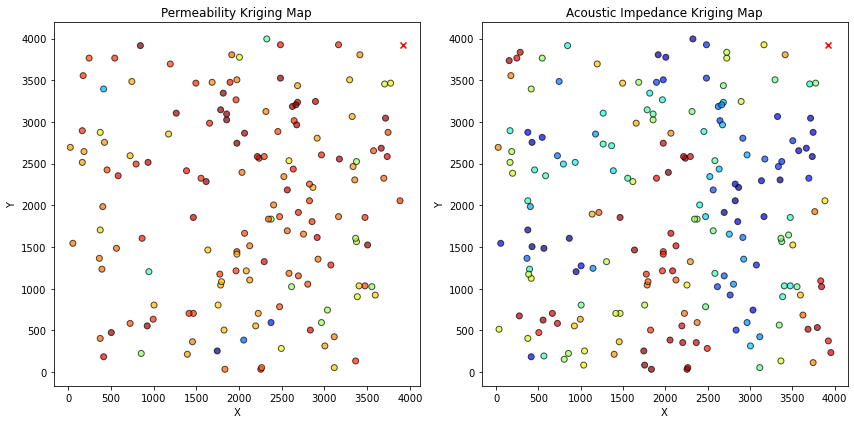

In [97]:
# Define range (r) and sill (s) for permeability and impedance
range_perm = 817.42
sill_perm = 3.95
range_impedance = 1493
sill_impedance = 0.38

# Perform ordinary kriging for permeability
interpolated_perm, _, _ = ordinary_kriging(dist_mat_perm, distances, np.log(data['permeability'].values), range_perm, sill_perm)

# Perform ordinary kriging for acoustic impedance
interpolated_impedance, _, _ = ordinary_kriging(dist_mat_impedance, distances, data['acoustic_impedance'].values, range_impedance, sill_impedance)

# Plot the kriging maps
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Permeability map
axs[0].scatter(data['X'], data['Y'], c=np.log(data['permeability']), cmap='jet', edgecolor='k', alpha=0.7)
axs[0].scatter(target_point[0], target_point[1], c='red', marker='x')
axs[0].set_title('Permeability Kriging Map')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

# Impedance map
axs[1].scatter(data['X'], data['Y'], c=data['acoustic_impedance'], cmap='jet', edgecolor='k', alpha=0.7)
axs[1].scatter(target_point[0], target_point[1], c='red', marker='x')
axs[1].set_title('Acoustic Impedance Kriging Map')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

plt.tight_layout()
plt.show()
